In [648]:
import seaborn as sns
from matplotlib import dates
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
import tabulate
warnings.filterwarnings('ignore')
# sns.set(font_scale=5.5)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
df_hrv = pd.read_csv("../data/original/HeartRateVariabilitySDNN.csv")
# df_hrv.head()

# df_new = pd.DataFrame(index=df_hrv.index)
# df_new['date'] = pd.to_datetime(df_hrv['creationDate'])
# df_new['hrv'] = df_hrv['value']
# new_date = []


# for (index, row) in df_new.iterrows():
#     new_date.append(np.datetime64('2005-02-25T03:30'))


# df_new['new date'] = new_date 
# df_new['new date'] = df_new['new date'].values.astype(float)  
# df_new.head()

# from pandas.plotting import autocorrelation_plot





In [993]:
def parse_date(x):
    return pd.datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S')

series = pd.read_csv('../data/original/HeartRateVariabilitySDNN.csv', header=0, index_col=5, parse_dates=[5], squeeze=True, date_parser=parse_date)

df_new = pd.DataFrame()
df_new['value'] = series['value'].resample('H').mean().interpolate()
df_new['creationDate'] = pd.to_datetime(df_new.index)
df_new = df_new.reset_index(drop=True)

df_new['t+1'] = df_new['value'].shift(periods=1)
df_new['t+24'] = df_new['value'].shift(periods=24)
df_new.head()



,value,creationDate,t+1,t+24
0,38.75470,2018-01-16 09:00:00,NaN,NaN
1,36.47938,2018-01-16 10:00:00,38.75470,NaN
2,34.20406,2018-01-16 11:00:00,36.47938,NaN
3,31.92874,2018-01-16 12:00:00,34.20406,NaN
4,29.65342,2018-01-16 13:00:00,31.92874,NaN


In [994]:
df_hrv_filtered = df_new

# convert from string to datetime
# df_hrv_filtered['creationDate'] = pd.to_datetime(df_hrv_filtered['creationDate'])
# mean per day
# df_hrv_final = df_hrv_filtered.groupby(df_hrv_filtered['creationDate'].dt.date).mean()

df_hrv_filtered.head()
    

,value,creationDate,t+1,t+24
0,38.75470,2018-01-16 09:00:00,NaN,NaN
1,36.47938,2018-01-16 10:00:00,38.75470,NaN
2,34.20406,2018-01-16 11:00:00,36.47938,NaN
3,31.92874,2018-01-16 12:00:00,34.20406,NaN
4,29.65342,2018-01-16 13:00:00,31.92874,NaN


,date,HRV (SDNN),Is at Work (binary),Is Above Mean Value,Hour of Day,Day of Week,Is Morning,t+1
0,2018-01-16 09:00:00,38.75470,1,0,9,2,1,NaN
1,2018-01-16 10:00:00,36.47938,1,0,10,2,1,38.75470
2,2018-01-16 11:00:00,34.20406,1,0,11,2,1,36.47938
3,2018-01-16 12:00:00,31.92874,1,0,12,2,0,34.20406
4,2018-01-16 13:00:00,29.65342,1,0,13,2,0,31.92874


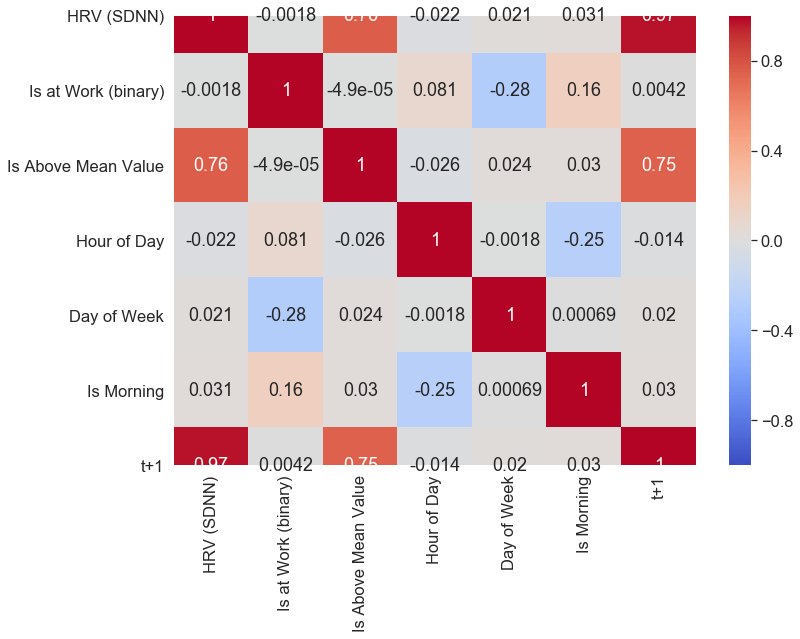

In [996]:
scaler = StandardScaler()
hrv_merged = pd.DataFrame()

def at_work(row):
#     print(row['creationDate'].hour)
    derp = row['creationDate'].hour
    hour = row['creationDate'].hour
    weekday = row['creationDate'].isoweekday()
    
    if((hour >= 9 and hour <17) and weekday < 6):
        # print(pd.to_datetime(row['creationDate']), (weekday))
        return 1
    return 0
    
# winter is from 1st of November to 1st of April
def is_winter(row):
    month = pd.to_datetime(row['creationDate'], format='%d/%m').month
    
    if(month >= 10 or month < 4):
        return 1
    return 0

def is_higher_than_mean(row):
    mean = 41.25
    if row.value > mean:
        return 1
    return 0

def get_hour_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    return hour

def get_day_of_week(row):
    weekday = pd.to_datetime(row['creationDate']).isoweekday()
    return weekday

def get_time_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    
    if((hour >= 6 and hour <12)):
        return 1
    return 0
    
    
hrv_merged['date'] = df_hrv_filtered['creationDate']
hrv_merged['HRV (SDNN)'] = df_hrv_filtered['value']

work_hours = []
winter_time = []
above_mean = []
hour_of_day = []
day_of_week = []
time_of_day = [] # is morning or afternoon



for (index, row) in df_hrv_filtered.iterrows():

        
    work_hours.append(at_work(row))
#     winter_time.append(is_winter(row))
    above_mean.append(is_higher_than_mean(row))
    hour_of_day.append(get_hour_of_day(row))
    day_of_week.append(get_day_of_week(row))
    time_of_day.append(get_time_of_day(row))
    if (row['value'] > 150):
        df_hrv_filtered.drop(index, inplace=True)
    
hrv_merged['Is at Work (binary)'] = work_hours
hrv_merged['Is Above Mean Value'] = above_mean
hrv_merged['Hour of Day'] = hour_of_day
hrv_merged['Day of Week'] = day_of_week
hrv_merged['Is Morning'] = time_of_day
# hrv_merged['new date'] = hrv_merged['date'].astype(np.int64).values.reshape(-1,1)
hrv_merged['t+1'] = df_hrv_filtered['t+1']

hrv_merged.to_csv('../data/hrv_shaped.csv')

sns.heatmap(hrv_merged.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

hrv_merged.head()

# hrv_copy = hrv_merged.set_index('date')
# hrv_scaled = scaler.fit_transform(hrv_copy)

# print(tabulate(hrv_summary, tablefmt="pipe", headers="keys"))
# results.head()

# hrv_copy = hrv_merged.set_index('date')

# hrv_copy.head()
# hrv_scaled = scaler.fit_transform(hrv_copy)
# # hrv_summary




# sx = sns.lineplot(x="date", y="HRV (SDNN)", data=hrv_merged)
# sx.set(xlim = (pd.to_datetime('2018-01-13'), pd.to_datetime('2019-10-31')))

# sx.set_title('HRV', fontsize=20)

# for item in sx.get_xticklabels():
#     item.set_rotation(45)
# hrv_merged.hist()

# new_pd = pd.DataFrame(hrv_scaled)

# new_pd.head()
# hrv_merged = hrv_merged.set_index('date')
# hrv_scaled = scaler.fit_transform(hrv_copy)
# df_hrv_scaled = pd.DataFrame(hrv_scaled)
# df_hrv_scaled.head(50)

# hrv_copy.head(10)

# fig = sx.get_figure()
# fig.savefig("../report/images/dataset_3.png")


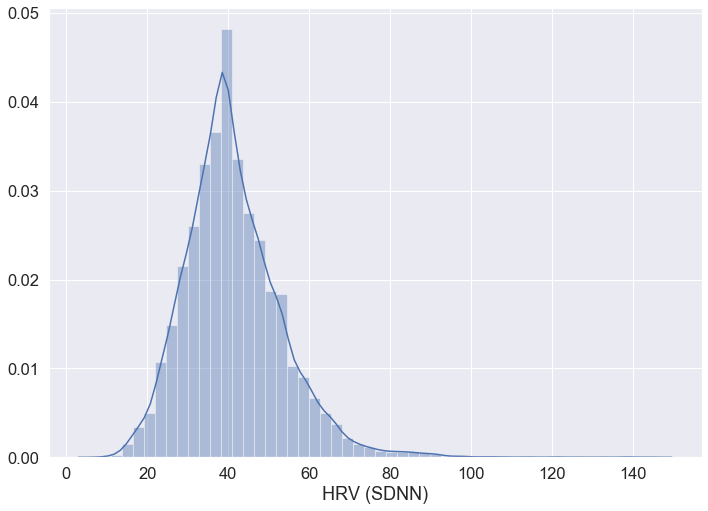

In [1010]:
# hrv_merged['HRV (SDNN)'].hist()
sns.distplot(hrv_merged['HRV (SDNN)'])

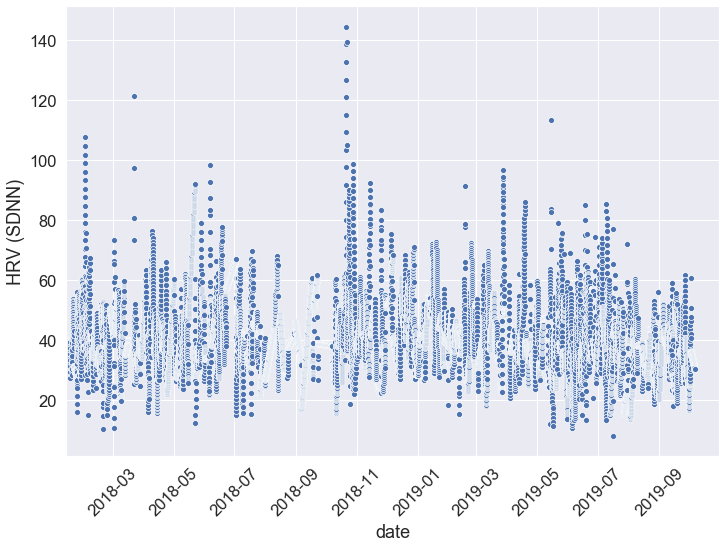

In [1011]:
ax = sns.scatterplot(x=hrv_merged['date'], y=hrv_merged['HRV (SDNN)'], data=hrv_merged)
ax.set(xlim = (pd.to_datetime('2018-01-13'), pd.to_datetime('2019-10-31')))
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [1014]:
hrv_copy = hrv_merged.set_index('date')


hrv_scaled = scaler.fit_transform(hrv_copy.dropna())

df_hrv_scaled = pd.DataFrame(hrv_scaled)
df_hrv_scaled.columns = ['HRV', 'At Work', 'Above Mean', 'Hour of day', 'Day of week', 'Is morning', 't+1']
# hrv_copy.head()
# df_hrv_scaled.corr() // It's the same as non-scaled values

df_hrv_scaled.head()


,HRV,At Work,Above Mean,Hour of day,Day of week,Is morning,t+1
0,-0.394288,1.787749,-0.886295,-0.216582,-1.003011,1.731744,-0.204286
1,-0.584178,1.787749,-0.886295,-0.072137,-1.003011,1.731744,-0.393880
2,-0.774069,1.787749,-0.886295,0.072309,-1.003011,-0.577452,-0.583475
3,-0.963959,1.787749,-0.886295,0.216755,-1.003011,-0.577452,-0.773069
4,-1.153850,1.787749,-0.886295,0.361201,-1.003011,-0.577452,-0.962663


# Linear regression

In [1015]:
from sklearn import linear_model, model_selection, metrics, preprocessing
import numpy as np

1. Split test and train data sets
2. Determine alpha interval
3. Type cohercion

In [1016]:
# stuff = hrv_merged['date'].astype(np.int64).values.reshape(-1,1)
X = df_hrv_scaled['t+1'].values.reshape(-1,1)
# X_raw = df_hrv_scaled[['Above Mean', 'Hour of day']]

# poly_features = preprocessing.PolynomialFeatures(degree=2)
# X = poly_features.fit_transform(X_raw)

y = df_hrv_scaled['HRV']

n_alphas = 100
alphas = np.logspace(-10, 10, n_alphas)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.20)

# print(stuff)

# hrv_merged['HRV (SDNN)'].describe()

# sns.lineplot(data=df_hrv_scaled, y=df_hrv_scaled['HRV'], x=df_hrv_scaled['new date'])
# stuff.flatten().shape
# df_hrv_scaled.shape

# from pandas.plotting import lag_plot

# lag_plot(hrv_merged[['date', 'HRV (SDNN)']])


In [1002]:
## Non-regularized linear regression
linreg = linear_model.LinearRegression().fit(X_train, y_train)
print('score: ', linreg.score(X_test, y_test))

y_pred_linreg = linreg.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linreg)))
# linreg.score()


# plt.scatter(X_test, y_test,  color='gray')
# plt.plot(X_test, y_pred, color='red', linewidth=2)
# plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Regularized linear regression

score 0.5335100123933951
coef [0.76366095]
intercept 0.002955823849980521
alpha 8.111308307896856
Root Mean Squared Error: 0.6808244640291173


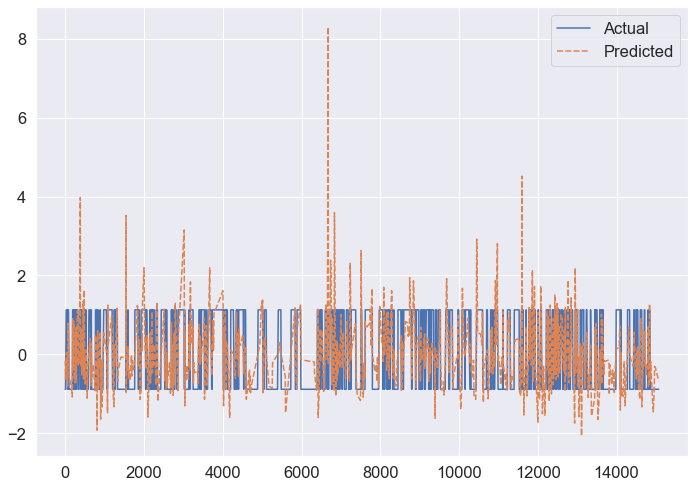

In [978]:
ridgeCV = linear_model.RidgeCV(alphas=alphas, cv=10)
ridgeCV.fit(X_train,y_train)

# print(X_test)

print('score', ridgeCV.score(X_test, y_test))
print('coef', ridgeCV.coef_)
print('intercept', ridgeCV.intercept_)
print('alpha',ridgeCV.alpha_)

y_pred_ridge = ridgeCV.predict(X_test)

df_actual_vs_pred = []
df_actual_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_ridge.flatten() })
df_actual_vs_pred.head()

sns.lineplot(data=df_actual_vs_pred)

# df_actual_vs_pred.describe()
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))


# df1 = df_actual_vs_pred.head(25)
# df1.plot(kind='bar',figsize=(16,10))
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.show()


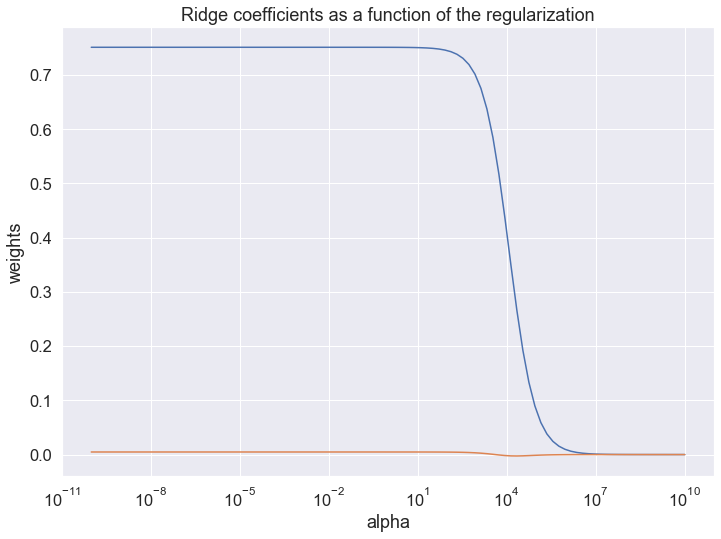

In [974]:
## NOTE: THESE VALUES HAVE TO BE SCALED

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
# print(coefs, alphas)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [946]:
## NOTE: THESE VALUES SHOULD _NOT_ BE SCALED

# alphas = list(range(0, 10, 0.1))

# print(alphas)

coefs = []
error_train = []
error_test = []

for a in alphas:
#     print(a)
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train,y_train)
    scores = model_selection.cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv = 10)
#     score_test = model_selection.cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv = 10)
#     score_test = model.score(X_test, y_test)
#     print(model.coef_)
    y_pred = model.predict(X_test)
#     print(y_pred)
#     print(a, model.coef_.mean())
    score_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    error_train.append(np.sqrt(-scores).mean())
    error_test.append(score_test)
    
#     print(a, (np.sqrt(-scores).mean()), score_test)
    

df_errors = pd.DataFrame({'lambda': alphas, 'Training Error': error_train, 'Test Error': error_test})
df_errors.columns = ['lambda', 'Training Error', 'Test Error']  
df_errors = df_errors.set_index(-np.log10(alphas))
print(-np.log10(1.29154967e+01))
# df_errors = df_errors.set_index(alphas)



# df_errors.head()
    

-1.1111111127873985


[Text(0, 0.5, 'Error (RMSE)'), Text(0.5, 0, '-log10(λ)')]

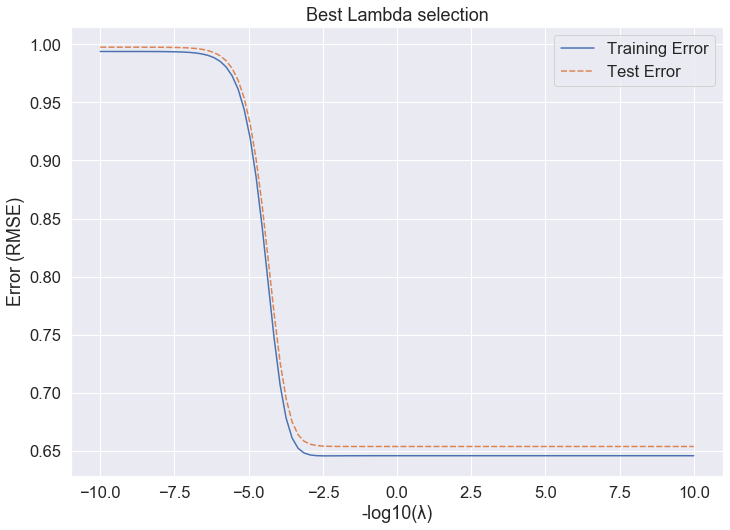

In [947]:
from matplotlib.colors import LogNorm

ex = sns.lineplot(data=df_errors[['Training Error', 'Test Error']])
ex.set_title('Best Lambda selection')
ex.set(xlabel='-log10(λ)', ylabel='Error (RMSE)')


# ex.set(xlim = (0,20))


## Test data set (predictions)

Mean Absolute Error: 0.4767813166001041
Mean Squared Error: 0.42755216178937533
Root Mean Squared Error: 0.42755216178937533


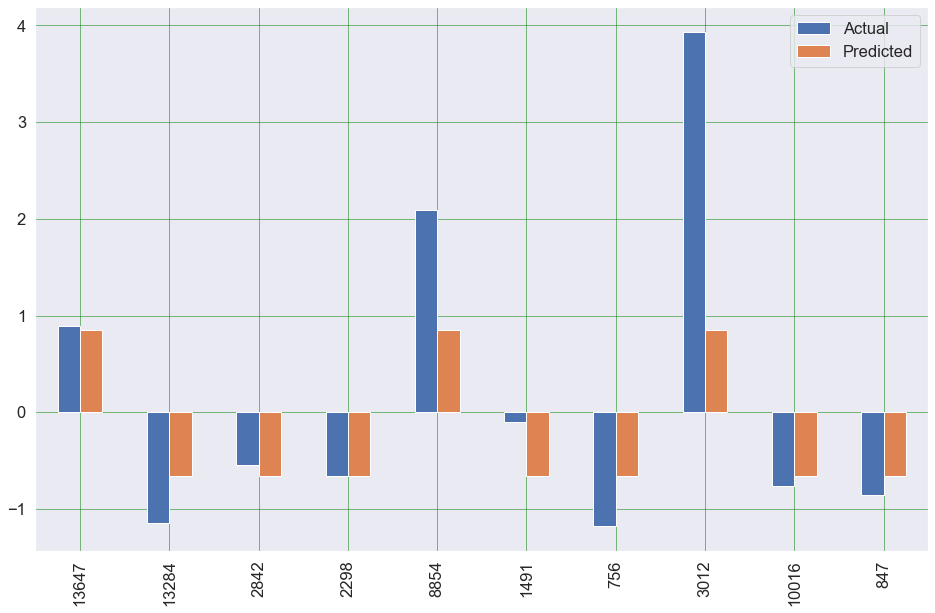

In [948]:
# y_pred = model.predict(X_test)

df_actual_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_ridge.flatten() })
df_actual_vs_pred.head()

# print(y_pred_ridge)

# sns.lineplot(data=df_actual_vs_pred['Actual'])

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ridge))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ridge))  
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ridge))

# df_actual_vs_pred.head(50)

df1 = df_actual_vs_pred.head(10)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()



In [538]:
print(X_train.shape)
print(y_train.shape)

# plt.scatter(X_train, y_train,  color='gray')
# plt.plot(X_train, y_pred, color='red', linewidth=2)
# plt.show()

(745, 1)
(745,)


0.0007733544622052606


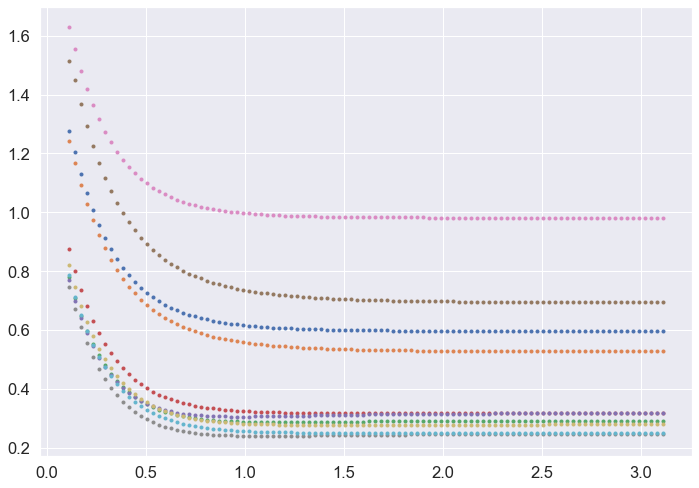

In [552]:
derp = linear_model.LassoCV(cv=10).fit(X_train, y_train)

print(derp.alpha_)
# Display results
m_log_alphas = -np.log10(derp.alphas_)

plt.figure()
plt.plot(m_log_alphas, derp.mse_path_, '.')

In [ ]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

## Kfolds

In [680]:
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)
# Initialize variable
Error_train = np.empty((0,K))
Error_test = np.empty((0,K))

i = 0 
for train_index, test_index in CV.split(X):
    print('Computing CV fold: {0}/{1}..'.format(i+1,K))

    # extract training and test set for current CV fold
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]
    
    linreg = linear_model.LinearRegression().fit(X_train, y_train)
    print('score: ', linreg.score(X_test, y_test))

    y_pred_linreg = linreg.predict(X_test)
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linreg)))
    # linreg.score()
    
    
    
    for a in alphas:
    # print(a)
        ridge = linear_model.Ridge(alpha=a)
        ridge.fit(X_train,y_train)
        ridge.score(X_test, y_test)
#         print('score: ', linreg.score(X_test, y_test))
        y_pred_ridge = ridge.predict(X_test)
        
        print('[Ridge] Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))
    
    i+=1

Computing CV fold: 1/10..
score:  0.6143262027247028
Root Mean Squared Error: 0.5749496598912627
[Ridge] Root Mean Squared Error: 0.5749496598912597
[Ridge] Root Mean Squared Error: 0.574949659891258
[Ridge] Root Mean Squared Error: 0.5749496598912552
[Ridge] Root Mean Squared Error: 0.5749496598912508
[Ridge] Root Mean Squared Error: 0.5749496598912438
[Ridge] Root Mean Squared Error: 0.5749496598912327
[Ridge] Root Mean Squared Error: 0.5749496598912148
[Ridge] Root Mean Squared Error: 0.5749496598911865
[Ridge] Root Mean Squared Error: 0.5749496598911414
[Ridge] Root Mean Squared Error: 0.5749496598910696
[Ridge] Root Mean Squared Error: 0.5749496598909554
[Ridge] Root Mean Squared Error: 0.5749496598907732
[Ridge] Root Mean Squared Error: 0.5749496598904833
[Ridge] Root Mean Squared Error: 0.5749496598900218
[Ridge] Root Mean Squared Error: 0.5749496598892868
[Ridge] Root Mean Squared Error: 0.5749496598881165
[Ridge] Root Mean Squared Error: 0.5749496598862532
[Ridge] Root Mean Sq

[Ridge] Root Mean Squared Error: 0.5692246353410848
[Ridge] Root Mean Squared Error: 0.5692246353410899
[Ridge] Root Mean Squared Error: 0.5692246353410981
[Ridge] Root Mean Squared Error: 0.569224635341111
[Ridge] Root Mean Squared Error: 0.5692246353411314
[Ridge] Root Mean Squared Error: 0.5692246353411642
[Ridge] Root Mean Squared Error: 0.5692246353412163
[Ridge] Root Mean Squared Error: 0.5692246353412992
[Ridge] Root Mean Squared Error: 0.5692246353414311
[Ridge] Root Mean Squared Error: 0.5692246353416415
[Ridge] Root Mean Squared Error: 0.5692246353419761
[Ridge] Root Mean Squared Error: 0.569224635342509
[Ridge] Root Mean Squared Error: 0.5692246353433575
[Ridge] Root Mean Squared Error: 0.5692246353447088
[Ridge] Root Mean Squared Error: 0.5692246353468603
[Ridge] Root Mean Squared Error: 0.5692246353502861
[Ridge] Root Mean Squared Error: 0.5692246353557409
[Ridge] Root Mean Squared Error: 0.5692246353644265
[Ridge] Root Mean Squared Error: 0.5692246353782565
[Ridge] Root M

[Ridge] Root Mean Squared Error: 0.6861002674632302
[Ridge] Root Mean Squared Error: 0.6861002674632405
[Ridge] Root Mean Squared Error: 0.6861002674632569
[Ridge] Root Mean Squared Error: 0.6861002674632829
[Ridge] Root Mean Squared Error: 0.6861002674633244
[Ridge] Root Mean Squared Error: 0.6861002674633906
[Ridge] Root Mean Squared Error: 0.6861002674634958
[Ridge] Root Mean Squared Error: 0.6861002674636633
[Ridge] Root Mean Squared Error: 0.6861002674639302
[Ridge] Root Mean Squared Error: 0.6861002674643548
[Ridge] Root Mean Squared Error: 0.6861002674650313
[Ridge] Root Mean Squared Error: 0.6861002674661081
[Ridge] Root Mean Squared Error: 0.6861002674678229
[Ridge] Root Mean Squared Error: 0.6861002674705535
[Ridge] Root Mean Squared Error: 0.6861002674749014
[Ridge] Root Mean Squared Error: 0.6861002674818241
[Ridge] Root Mean Squared Error: 0.6861002674928471
[Ridge] Root Mean Squared Error: 0.6861002675103992
[Ridge] Root Mean Squared Error: 0.6861002675383467
[Ridge] Root

[Ridge] Root Mean Squared Error: 0.6131200089291895
[Ridge] Root Mean Squared Error: 0.6131200089289953
[Ridge] Root Mean Squared Error: 0.6131200089286863
[Ridge] Root Mean Squared Error: 0.6131200089281942
[Ridge] Root Mean Squared Error: 0.6131200089274107
[Ridge] Root Mean Squared Error: 0.6131200089261631
[Ridge] Root Mean Squared Error: 0.6131200089241764
[Ridge] Root Mean Squared Error: 0.6131200089210133
[Ridge] Root Mean Squared Error: 0.6131200089159766
[Ridge] Root Mean Squared Error: 0.6131200089079566
[Ridge] Root Mean Squared Error: 0.6131200088951867
[Ridge] Root Mean Squared Error: 0.6131200088748535
[Ridge] Root Mean Squared Error: 0.613120008842477
[Ridge] Root Mean Squared Error: 0.6131200087909247
[Ridge] Root Mean Squared Error: 0.6131200087088388
[Ridge] Root Mean Squared Error: 0.6131200085781344
[Ridge] Root Mean Squared Error: 0.6131200083700168
[Ridge] Root Mean Squared Error: 0.6131200080386343
[Ridge] Root Mean Squared Error: 0.6131200075109795
[Ridge] Root 

[Ridge] Root Mean Squared Error: 0.6357267776058975
[Ridge] Root Mean Squared Error: 0.6357267776058901
[Ridge] Root Mean Squared Error: 0.6357267776058781
[Ridge] Root Mean Squared Error: 0.6357267776058589
[Ridge] Root Mean Squared Error: 0.6357267776058286
[Ridge] Root Mean Squared Error: 0.6357267776057804
[Ridge] Root Mean Squared Error: 0.6357267776057034
[Ridge] Root Mean Squared Error: 0.6357267776055809
[Ridge] Root Mean Squared Error: 0.635726777605386
[Ridge] Root Mean Squared Error: 0.6357267776050756
[Ridge] Root Mean Squared Error: 0.635726777604581
[Ridge] Root Mean Squared Error: 0.6357267776037938
[Ridge] Root Mean Squared Error: 0.6357267776025404
[Ridge] Root Mean Squared Error: 0.6357267776005446
[Ridge] Root Mean Squared Error: 0.6357267775973666
[Ridge] Root Mean Squared Error: 0.6357267775923063
[Ridge] Root Mean Squared Error: 0.635726777584249
[Ridge] Root Mean Squared Error: 0.6357267775714195
[Ridge] Root Mean Squared Error: 0.6357267775509913
[Ridge] Root Me

[Ridge] Root Mean Squared Error: 1.4136692314880626


In [685]:
X_train_perfect, X_test_perfect, y_train_perfect, y_test_perfect = X_train, X_test, y_train, y_test

In [689]:
%store X_train_perfect
%store X_test_perfect
%store y_train_perfect 
%store y_test_perfect
%store X
%store y

Stored 'X_train_perfect' (ndarray)
Stored 'X_test_perfect' (ndarray)
Stored 'y_train_perfect' (Series)
Stored 'y_test_perfect' (Series)
Stored 'X' (ndarray)
Stored 'y' (Series)
